# Redução de dimensionalidade via PCA

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import common as com
import pca
import neural_networks as neural_network

import sklearn.datasets as datasets
from sklearn.datasets import fetch_openml

train_ratio = 0.8
validation_ratio = 0.2

normalize_data = True
apply_pca = True
pca_explain = 0.8

np.random.seed(12345)

#data = fetch_openml(name='mfeat-karhunen')
#data = fetch_openml(name='heart-statlog')
#data = fetch_openml(name='vehicle')
#data = fetch_openml(name='sonar')
#data = fetch_openml(name='glass')
#data = fetch_openml(name='ecoli')
#data = fetch_openml(name='yeast')
#data = fetch_openml(name='splice')
#data = fetch_openml(name='vowel')
#data = fetch_openml(name='credit-g')
#data = fetch_openml(name='spambase')
data = fetch_openml(name='mnist_784')
#data = fetch_openml(name='Fashion-MNIST')
label_names = np.unique(data.target)
x = data.data
y = np.zeros(data.target.shape[0], dtype=int)
for k, k_label in enumerate(label_names):
    y[data.target == k_label] = k

#data_table = pd.read_csv('data/ex2data1.txt', header=None)
#data_table = pd.read_csv('data/ex2data2.txt', header=None)
#data_table = pd.read_csv('data/blobs.txt', header=None)
#data_table = pd.read_csv('data/blobs2.txt', header=None)
#data_table = pd.read_csv('data/moons.txt', header=None)
#x = data_table.drop(data_table.columns[-1], axis=1).values
#y = data_table.iloc[:,data_table.columns[-1]].values
#label_names = np.unique(y)

#x, y = datasets.load_iris(return_X_y=True); label_names = datasets.load_iris()['target_names']
#x, y = datasets.load_digits(return_X_y=True); label_names = datasets.load_digits()['target_names']
#x, y = datasets.load_wine(return_X_y=True); label_names = datasets.load_wine()['target_names']
#x, y = datasets.load_breast_cancer(return_X_y=True); label_names = datasets.load_breast_cancer()['target_names']
#data = datasets.fetch_olivetti_faces(); x, y = data['data'], data['target']; label_names = np.unique(data['target'])

print("Número de padrões: %d" % x.shape[0])
print("Número de atributos: %d" % x.shape[1])
print("Número de classes: %d" % np.unique(y).shape[0])

Número de padrões: 70000
Número de atributos: 784
Número de classes: 10


## Divisão treino/teste e normalização dos dados

In [31]:
number_train = int(np.ceil(train_ratio*(x.shape[0])))
random_index = np.random.permutation(x.shape[0])
train_index = random_index[:number_train+1]
test_index = random_index[number_train+1:]

x_train = x[train_index]
x_test = x[test_index]
y_train = y[train_index]
y_test = y[test_index]

print("Número de padrões de treinamento: %d" % len(train_index))
print("Número de padrões de teste: %d" % len(test_index))

if normalize_data:

    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_std = np.std(x_train, axis=0)
    index_not_zero = x_std > 0
    x_train[:,index_not_zero] /= x_std[index_not_zero]

    x_test -= x_train_mean
    x_test[:,index_not_zero] /= x_std[index_not_zero]

Número de padrões de treinamento: 56001
Número de padrões de teste: 13999


## Compactação via PCA

Número de atributos antes do PCA: 784
Número de atributos após o PCA: 147


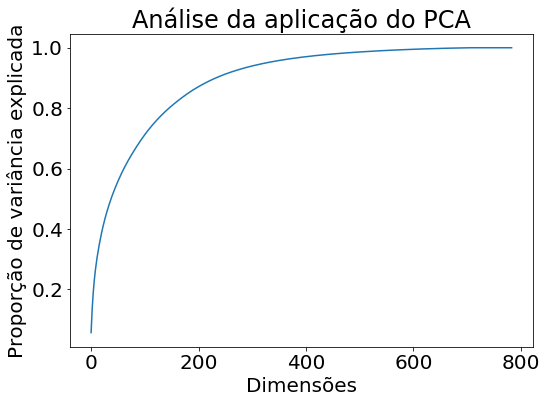

In [32]:
if apply_pca:
    print("Número de atributos antes do PCA: %d" % x_train.shape[1])
    pca_result = pca.compute(x_train)
    x_train = pca.transform(x_train, pca_result, explain=pca_explain)
    x_test = pca.transform(x_test, pca_result, explain=pca_explain)
    print("Número de atributos após o PCA: %d" % x_train.shape[1])
    
    explained_variance = np.cumsum(pca_result['eigen_values'])
    fig = plt.figure(figsize=com.figsize)
    plt.rcParams.update({'font.size': com.fontsize})
    plt.plot(explained_variance/explained_variance[-1])
    plt.xlabel("Dimensões")
    plt.ylabel("Proporção de variância explicada")
    plt.title("Análise da aplicação do PCA")
    plt.savefig('figs/pca_mnist_var.png', dpi=com.dpi)

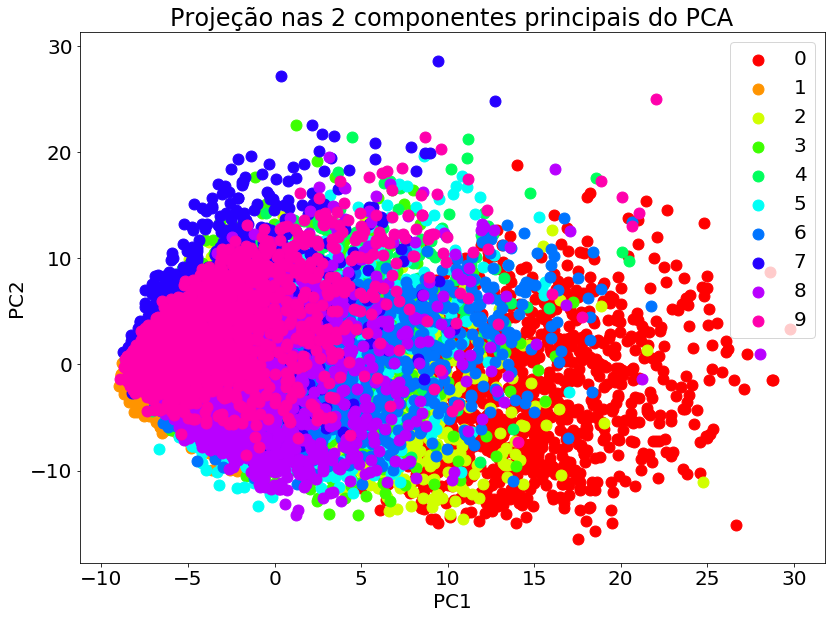

In [33]:
def plot_data(x, y, marker='o', legend=False, color=None):
    labels = np.unique(y)
    colors = plt.cm.hsv(np.linspace(0, 0.9, labels.shape[0]))
    plt.rcParams.update({'font.size': com.fontsize})
    for i, label in enumerate(labels):
        if color == 'bw':
            plt.scatter(x[y == label,0], x[y == label,1], s=10*com.markersize, marker=marker, color='k', label=label)  
        else:    
            plt.scatter(x[y == label,0], x[y == label,1],
                        s=10*com.markersize, marker=marker, color=colors[i], label=label)      
            
    if legend:
        plt.legend()

fig = plt.figure(figsize=(12,9))
plot_data(x_test, y_test, legend=True)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projeção nas 2 componentes principais do PCA")
plt.savefig('figs/pca_mnist.png', dpi=com.dpi)
plt.show()

## One-hot-encoding

In [4]:
if np.unique(y).shape[0] > 2:
    y_train_encoding = np.zeros((y_train.shape[0], max(y)+1))
    for i in range(y_train_encoding.shape[0]):
        y_train_encoding[i,y_train[i]] = 1
    y_test_encoding = np.zeros((y_test.shape[0], max(y)+1))
    for i in range(y_test_encoding.shape[0]):
        y_test_encoding[i,y_test[i]] = 1
else:
    y_train_encoding = y_train
    y_test_encoding = y_test

## Solução via MLP

Taxa de erro no treinamento: 1.61%
Taxa de erro no teste: 3.51%


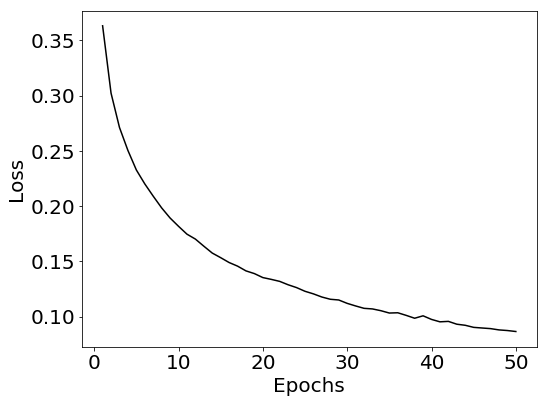

In [5]:
num_hidden_nodes = 100
activation = 'relu'
output = 'classification'
alpha = 10**-2
mini_batch_size = 100
num_epochs = 50
momentum = 0.9
weight_decay = 0
model_mlp = neural_network.mlp_train(x=x_train, y=y_train_encoding,
                                     num_hidden_nodes=num_hidden_nodes, activation=activation, output=output,
                                     num_epochs=num_epochs, alpha=alpha, mini_batch_size=mini_batch_size,
                                     momentum=momentum, weight_decay=weight_decay, compute_loss=True)  

loss_history_mlp = model_mlp['loss_history']
loss_mlp = loss_history_mlp[-1]

if len(loss_history_mlp) > 1:
    plt.figure(figsize=com.figsize)
    plt.rcParams.update({'font.size': com.fontsize})
    plt.plot(np.arange(1,len(loss_history_mlp)+1), loss_history_mlp, '-k')
    plt.xlabel('Epochs', fontsize=com.fontsize)
    plt.ylabel('Loss', fontsize=com.fontsize)
    #plt.savefig('figs/mlp_mnist_loss_pca.png', dpi=com.dpi)
    
wrong_index_train = y_train != neural_network.mlp_predict(model_mlp, x_train, return_class=True)
wrong_index_test = y_test != neural_network.mlp_predict(model_mlp, x_test, return_class=True)    

print("Taxa de erro no treinamento: %.2f%%" % (100*np.mean(wrong_index_train)))
print("Taxa de erro no teste: %.2f%%" % (100*np.mean(wrong_index_test)))